# Rebust Url Malware Detection
some explanning

In [13]:
import numpy as np
import seaborn as sns 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from ast import literal_eval # Transform/Parse a string-list into a proper list.
import requests
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
import swifter

In [7]:
df = pd.read_csv("Data/malicious_phish.csv")
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


<AxesSubplot:xlabel='type', ylabel='count'>

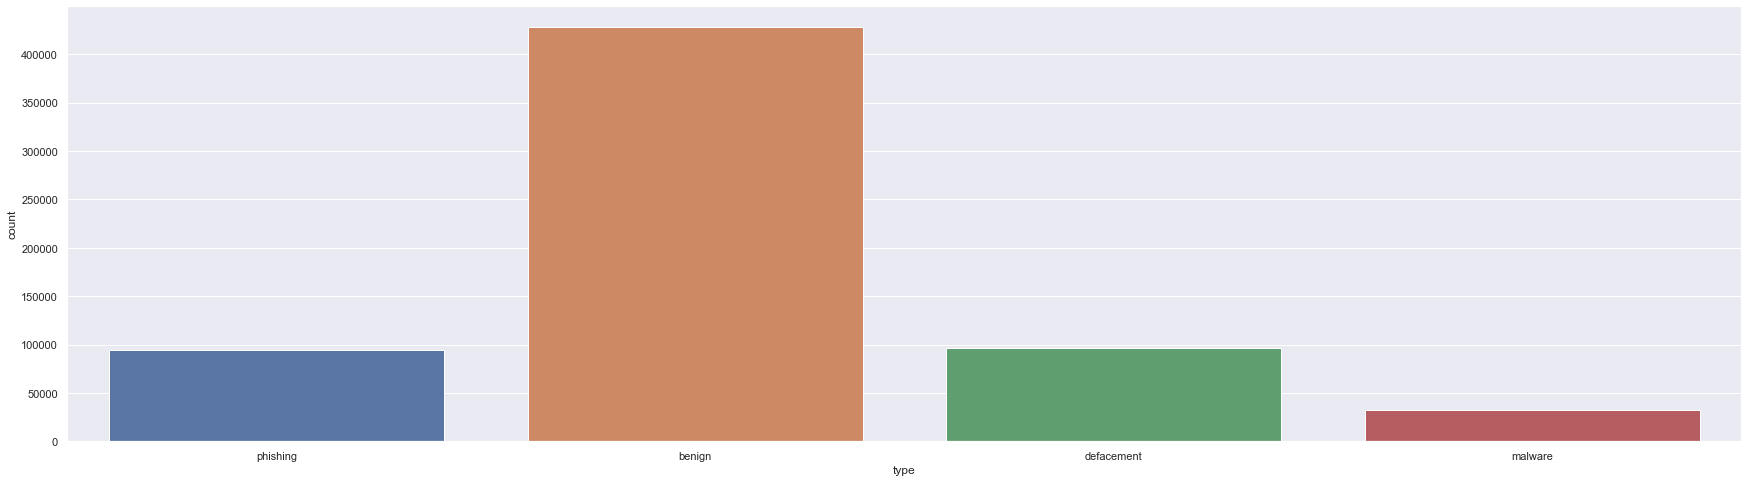

In [8]:
sns.set(rc={'figure.figsize':(30,8)})
sns.countplot(data=df, x='type')

In [9]:
(df['type']=='benign').sum(),(df['type']!='benign').sum()

(428103, 223088)

In [10]:
df.isna().sum()

url     0
type    0
dtype: int64

In [11]:
df['type'] = pd.Categorical(df['type'])
df['type'] = df['type'].cat.codes
df

,url,type
0,br-icloud.com.br,3
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,1
4,http://adventure-nicaragua.net/index.php?optio...,1
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,3
651188,www.gamespot.com/xbox360/action/deadspace/,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),3


## Preproccess

### Lexical Features: 
These refer to statistical features extracted from the literal URL string. For example, length of the URL string, number of digits, number of parameters in its query part, if the URL is encoded, etc.
see https://towardsdatascience.com/extracting-feature-vectors-from-url-strings-for-malicious-url-detection-cbafc24737a

In [30]:
from math import log
from re import compile
from urllib.parse import urlparse
from socket import gethostbyname
from pyquery import PyQuery
from requests import get
from json import dump
from string import ascii_lowercase
from numpy import array


class LexicalURLFeature:
    def __init__(self, url):
        self.description = 'blah'
        self.url = url
        self.urlparse = urlparse(self.url)
        self.host = self.__get_ip()


    def __get_entropy(self, text):
        text = text.lower()
        probs = [text.count(c) / len(text) for c in set(text)]
        entropy = -sum([p * log(p) / log(2.0) for p in probs])
        return entropy

    def __get_ip(self):
        try:
            ip = self.urlparse.netloc if self.url_host_is_ip() else gethostbyname(self.urlparse.netloc)
            return ip
        except:
            return None

    # extract lexical features
    def url_scheme(self):
        print(self.url)
        print(self.urlparse)
        return self.urlparse.scheme

    def url_length(self):
        return len(self.url)

    def url_path_length(self):
        return len(self.urlparse.path)

    def url_host_length(self):
        return len(self.urlparse.netloc)

    def url_host_is_ip(self):
        host = self.urlparse.netloc
        pattern = compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
        match = pattern.match(host)
        return match is not None

    def url_has_port_in_string(self):
        has_port = self.urlparse.netloc.split(':')
        return len(has_port) > 1 and has_port[-1].isdigit()

    def number_of_digits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def number_of_parameters(self):
        params = self.urlparse.query
        return 0 if params == '' else len(params.split('&'))

    def number_of_fragments(self):
        frags = self.urlparse.fragment
        return len(frags.split('#')) - 1 if frags == '' else 0

    def is_encoded(self):
        return '%' in self.url.lower()

    def num_encoded_char(self):
        encs = [i for i in self.url if i == '%']
        return len(encs)

    def url_string_entropy(self):
        return self.__get_entropy(self.url)

    def number_of_subdirectories(self):
        d = self.urlparse.path.split('/')
        return len(d)

    def number_of_periods(self):
        periods = [i for i in self.url if i == '.']
        return len(periods)

    def has_client_in_string(self):
        return 'client' in self.url.lower()

    def has_admin_in_string(self):
        return 'admin' in self.url.lower()

    def has_server_in_string(self):
        return 'server' in self.url.lower()

    def has_login_in_string(self):
        return 'login' in self.url.lower()
        
    def get_tld(self):
        return seelf.urlparse.netloc.split('.')[-1].split(':')[0]

### Content-Based Features


In [ ]:
from urllib.parse import urlparse
from pyquery import PyQuery
from requests import get
from socket import gethostbyname
from numpy import array, log
from string import punctuation
from json import dump, loads
from re import compile

class ContentFeatures:
    def __init__(self, url, vd = vd, sf = sf):
        self.url = url
        self.urlparse = urlparse(self.url)
        self.html = self.__get_html()
        self.pq = self.__get_pq()
        self.scripts = self.__get_scripts()
        self.valid_tags = vd
        self.suspicious_functions = sf
        self.host = self.__get_ip()

    def __get_ip(self):
        try:
            ip = self.urlparse.netloc if self.url_host_is_ip() else gethostbyname(self.urlparse.netloc)
            return ip
        except:
            return None


    def url_host_is_ip(self):
        host = self.urlparse.netloc
        pattern = compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
        match = pattern.match(host)
        return match is not None

    def __get_html(self):
        try:
            html = get(self.url, timeout=5)
            html = html.text if html else None
        except:
            html = None
        return html

    def __get_pq(self):
        try:
            pq = PyQuery(self.html) if self.html else None
            return pq
        except:
            return None


    def __get_scripts(self):
        scripts = self.pq('script') if self.pq else None
        return scripts

    def __get_entropy(self, text):
        text = text.lower()
        probs = [text.count(c) / len(text) for c in set(text)]
        return -sum([p * log(p) / log(2.0) for p in probs])

    # extract content-based features
    def url_page_entropy(self):
        return self.__get_entropy(self.html)

    def number_of_script_tags(self):
        return len(self.scripts) if self.scripts else None

    def script_to_body_ratio(self):
        if self.scripts:
            scripts = self.scripts.text()
            return len(scripts)/self.length_of_html()
        else:
            return None

    def length_of_html(self):
        return len(self.html)

    def number_of_page_tokens(self):
        html_tokens = len(self.html.lower().split()) if self.html else None
        return html_tokens

    def number_of_sentences(self):
        html_sentences = len(self.html.split('.')) if self.html else None
        return html_sentences

    def number_of_punctuations(self):
        excepts = ['<', '>', '/']
        matches = [i for i in self.html if i in punctuation and i not in excepts]
        return len(matches)

    def number_of_distinct_tokens(self):
        html_tokens = [i.strip() for i in self.html.lower().split()]
        return len(set(html_tokens))

    def number_of_capitalizations(self):
        uppercases = [i for i in self.html if i.isupper()]
        return len(uppercases)

    def average_number_of_tokens_in_sentence(self):
        html_sentences = self.html.split('.')
        sen_lens = [len(i.split()) for i in html_sentences]
        return sum(sen_lens)/len(sen_lens)

    def number_of_html_tags(self):
        return len(self.pq('*')) if self.pq else None

    def number_of_hidden_tags(self):
        hidden1, hidden2 = self.pq('.hidden'), self.pq('#hidden')
        hidden3, hidden4 = self.pq('*[visibility="none"]'), self.pq('*[display="none"]')
        hidden = hidden1 + hidden2 + hidden3 + hidden4
        return len(hidden)

    def number_iframes(self):
        iframes = self.pq('iframe') + self.pq('frame')
        return len(iframes)

    def number_objects(self):
        objects = self.pq('object')
        return len(objects)

    def number_embeds(self):
        objects = self.pq('embed')
        return len(objects)

    def number_of_hyperlinks(self):
        hyperlinks = self.pq('a')
        return len(hyperlinks)

    def number_of_whitespace(self):
        whitespaces = [i for i in self.html if i == ' ']
        return len(whitespaces)

    def number_of_included_elements(self):
        toi = self.pq('script') + self.pq('iframe') + self.pq('frame') + self.pq('embed') + self.pq('form') + self.pq('object')
        toi = [tag.attr('src') for tag in toi.items()]
        return len([i for i in toi if i])

    def number_of_suspicious_elements(self):
        all_tags = [i.tag for i in self.pq('*')]
        suspicious = [i for i in all_tags if i not in self.valid_tags]
        return len(suspicious)

    def number_of_double_documents(self):
        tags = self.pq('html') + self.pq('body') + self.pq('title')
        return len(tags) - 3

    def number_of_eval_functions(self):
        scripts = self.pq('script')
        scripts = ['eval' in script.text().lower() for script in scripts.items()]
        return sum(scripts)

    def average_script_length(self):
        scripts = self.pq('script')
        scripts = [len(script.text()) for script in scripts.items()]
        l = len(scripts)
        if l > 0:
            return sum(scripts) / l
        else:
            return 0

    def average_script_entropy(self):
        scripts = self.pq('script')
        scripts = [self.__get_entropy(script.text()) for script in scripts.items()]
        l = len(scripts)
        if l > 0:
            return sum(scripts) / l
        else:
            return 0

    def number_of_suspicious_functions(self):
        script_content = self.pq('script').text()
        susf = [1 if i in script_content else 0 for i in self.suspicious_functions]
        return sum(susf)

### Host-Based Features


In [34]:
from whois import whois
from waybackpy import Cdx
from socket import gethostbyname
from shodan import Shodan
from requests import get
from urllib.parse import urlparse
from datetime import datetime
from re import compile
from json import dump, loads
from time import sleep

class HostFeatures:
    def __init__(self, url):
        self.url = url
        self.urlparse = urlparse(self.url)
        self.host = self.__get_ip()
        self.now = datetime.now()
        self.init_sub_params = self.initialise_sub_parameters()

    def initialise_sub_parameters(self):
        if self.host not in cache:
            self.whois = self.__get__whois_dict()
            self.shodan = self.__get_shodan_dict()
            self.snapshots = self.__get_site_snapshots()
            return True
        else:
            return False

    def __get_ip(self):
        try:
            ip = self.urlparse.netloc if self.url_host_is_ip() else gethostbyname(self.urlparse.netloc)
            return ip
        except:
            return None

    def __get__whois_dict(self):
        try:
            whois_dict = whois(self.host)
            return whois_dict
        except:
            return {}

    def __get_shodan_dict(self):
        api = Shodan('W6cy1PGcje0jJwKDBTgrqWSZioRpRmzg')
        try:
            host = api.host(self.host)
            return host
        except:
            return {}

    def __parse__before__date(self, date_string):
        month_year = date_string.split()[-1]
        d = '01-{}'.format(month_year)
        d = datetime.strptime(d, '%d-%b-%Y')
        return d

    def __parse_whois_date(self, date_key):
        cdate = self.whois.get(date_key, None)
        if cdate:
            if isinstance(cdate, str) and 'before' in cdate:
                d = self.__parse__before__date(cdate)
            elif isinstance(cdate, list):
                d = cdate[0]
            else:
                d = cdate
        return d if cdate else cdate

    def __get_site_snapshots(self):
        try:
            snapshots = Cdx(self.urlparse.netloc).snapshots()
            snapshots = [snapshot.datetime_timestamp for snapshot in snapshots]
            return snapshots
        except:
            return []

    def url_host_is_ip(self):
        host = self.urlparse.netloc
        pattern = compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
        match = pattern.match(host)
        return match is not None

    def number_of_subdomains(self):
        ln1 = self.whois.get('nets', None)
        ln2 = self.shodan.get('domains', None)
        ln = ln1 or ln2
        return len(ln) if ln else None

    def url_creation_date(self):
        d = self.__parse_whois_date('creation_date')
        return d

    def url_expiration_date(self):
        d = self.__parse_whois_date('expiration_date')
        return d

    def url_last_updated(self):
        d = self.__parse_whois_date('updated_date')
        return d

    def url_age(self):
        try:
            days = (self.now - self.url_creation_date()).days
        except:
            days = None
        return days

    def url_intended_life_span(self):
        try:
            lifespan = (self.url_expiration_date() - self.url_creation_date()).days
        except:
            lifespan = None
        return lifespan

    def url_life_remaining(self):
        try:
            rem = (self.url_expiration_date() - self.now).days
        except:
            rem = None
        return rem

    def url_registrar(self):
        return self.whois.get('registrar', None)

    def url_registration_country(self):
        c = self.whois.get('country', None)
        return c

    def url_host_country(self):
        c = self.shodan.get('country_name', None)
        return c

    def url_open_ports(self):
        ports = self.shodan.get('ports', '')
        return ports if ports != '' else None

    def url_num_open_ports(self):
        ports = self.url_open_ports()
        lp = len(ports) if ports else 0
        return lp

    def url_is_live(self):
        url = '{}://{}'.format(self.urlparse.scheme, self.urlparse.netloc)
        try:
            return get(url).status_code == 200
        except:
            return False

    def url_isp(self):
        return self.shodan.get('isp', '')

    def url_connection_speed(self):
        url = '{}://{}'.format(self.urlparse.scheme, self.urlparse.netloc)
        if self.url_is_live():
            return get(url).elapsed.total_seconds()
        else:
            return None

    def first_seen(self):
        try:
            fs = self.snapshots[0]
            return fs
        except:
            return datetime.now()

    def get_os(self):
        oss = self.shodan.get('os', None)
        return oss

    def last_seen(self):
        try:
            ls = self.snapshots[-1]
            return ls
        except:
            return datetime.now()

    def days_since_last_seen(self):
        dsls = (self.now - self.last_seen()).days
        return dsls

    def days_since_first_seen(self):
        dsfs = (self.now - self.first_seen()).days
        return dsfs

    def average_update_frequency(self):
        snapshots = self.snapshots
        diffs = [(t-s).days for s, t in zip(snapshots, snapshots[1:])]
        l = len(diffs)
        if l > 0:
            return sum(diffs)/l
        else:
            return 0

    def number_of_updates(self):
        return len(self.snapshots)

    def ttl_from_registration(self):
        earliest_date_seen = self.first_seen()
        try:
            ttl_from_reg = (earliest_date_seen - self.url_creation_date()).days
        except:
            ttl_from_reg = None
        return ttl_from_reg

ModuleNotFoundError: No module named 'waybackpy'

## Models

In [26]:
sns.heatmap(df.corr(), cmap='Blues')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2,  random_state=42)
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

In [ ]:
pca = PCA(n_components=0.99)
pca_X = pca.fit_transform(X_train)
pca_X

In [ ]:
import xgboost as xgb
def xgboost_pipeline(x_train, y_train, x_test,num_round=1000,thr=0.5):
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,random_state=1)
    param = {"learning_rate": 0.05, "max_depth": 8, "min_child_weight": 1, "gamma": 0, "subsample": 0.7,
             "objective": 'binary:logistic', "scale_pos_weight": 1, "seed": 93, "eval_metric": "logloss"}
    # "colsample_bytree":0.8# evals=evals, early_stopping_rounds=10
    d_train = xgb.DMatrix(x_train, label=y_train)
    d_eval = xgb.DMatrix(x_val, label=y_val)
    evallist = [(d_eval, 'eval'), (d_train, 'train')]
    bst = xgb.train(param, d_train, num_round, evallist)
    d_test = xgb.DMatrix(x_test)
    xgboost_pred = bst.predict(d_test)
    xgboost_pred[xgboost_pred > thr] = 1
    xgboost_pred[xgboost_pred <= thr] = 0
    return xgboost_pred,bst

In [ ]:
xgboost_pred,bst_binary = xgboost_pipeline(X_train,y_train,X_test)
print(classification_report(y_test, xgboost_pred))

In [ ]:
clf = RandomForestClassifier(max_depth=8, random_state=0,)
clf.fit(X_train, y_train)
clf_prediction = clf.predict(X_test)
print(classification_report(y_test, clf_prediction))

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
print(classification_report(y_test,pred))